In [2]:
'''Import all the necessary packages'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost

from patsy import dmatrix
from scipy import stats

import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import requests
from bs4 import BeautifulSoup

import seaborn as sns
from statsmodels.graphics import utils

/Users/Dong-hyun/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Dong-hyun/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 머신러닝 팀프로젝트 과제 발표

## 주제 : Shelter Animal Outcomes

#### DataSet

In [2]:
data_train = pd.read_csv('train.csv')
pd.set_option('display.max_rows', 40)

'''Keep a copy of the original data for comparison'''
data_original = data_train.copy()

In [3]:
data_train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A706797,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [4]:
#train_Data 확인
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26724,A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [5]:
#test_Data 확인
pd.read_csv('test.csv').tail()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11451,11452,NaN,2014-07-08 14:50,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
11452,11453,NaN,2014-10-21 12:57,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue
11453,11454,NaN,2014-09-29 9:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40,Dog,Intact Male,4 years,Labrador Retriever,Cream


* **test_dataset**에 없는 **OutcomeSubtype**은 최종결과에서 제외함.
* 위의 독립변수는 **종속변수에 대한 부가설명**이므로 이를 독립변수로 활용한다면 그 개념상 이미 작성된 답안지의 설명부분을 가지고 문제를 푸는 모습이 되어버림.
* 단, 이를 명시적으로 보여주기 위해서 분석과정에서는 다룰 예정임.

In [6]:
# 종속변수 Unique_Values 확인
data_train.OutcomeType.unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

# 개요


## 문제정의

**7개의 독립변수를 활용하여 보호소에 있는 각 동물이 종속변수의 5가지 유형 중 어느 것에 해당할 것인지 분류하는 문제.**

* 독립변수
 > Name : 발견당시 이름표 등에 표시되어 있던 이름. 주인이 지어준 것으로 예상됨.

 > DateTime : Outcome이 발생한 날짜와 시간.

 > AnimalType : 개와 고양이 두 종류.

 > SexuponOutcome : Outcome이 발생하는 시점에서의 해당 동물의 성별. 중성화 여부가 반영됨.

 > AgeuponOutcome : Outcome이 발생하는 시점에서의 해당 동물의 나이.

 > Breed : 해당 동물의 종. 

 > Color : 해당 동물의 색. 

* 종속변수 (**주인 찾아감 / 안락사 / 입양 / 타기관이송 / 사망**)



## 목표

**Log-Loss 의 최소화**

## 분석설계

#### 1. EDA
* Nan_Value
* Feature Engineering
* One-Hot-Encoding

#### 2. Feature Selection
* Greedy Search

#### 3. Modeling
* Logistic
* LDA/QDA
* Random Forest
* XG-boost

#### 4. Model Selection



# EDA

## Nan_value

In [7]:
def graph_na(data_train):
    plt.figure()
    missing_data_count = data_train.isnull().sum()
    missing_data_count.sort_values(ascending = False, inplace = True)
    missing_data_count_filtered = missing_data_count[missing_data_count > 0]
    missing_data_count_filtered.plot(kind = 'bar', title = 'missing data count')
    plt.show()

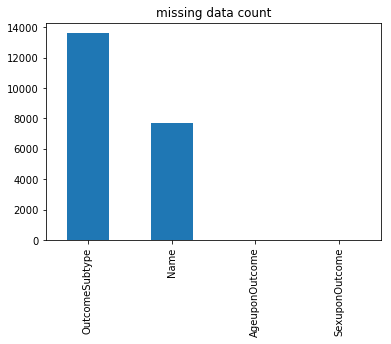

In [8]:
graph_na(data_train)

#### Name -> 유/무에 따라 해당 동물에 대한 주인의 애착 정도를 반영한다고 추측함. 따라서 유/무에 따른 결과값 분석 필요
#### OutcomeSubtype -> OutcomeType과 직관적으로 연결된 인자 (데이터 분석에는 적용 x)
#### AgeUponOutcome과 SexuponOutcome NaN값은 갯수가 많지 않기 때문에 제거

## Feature Engineering

## 종속변수

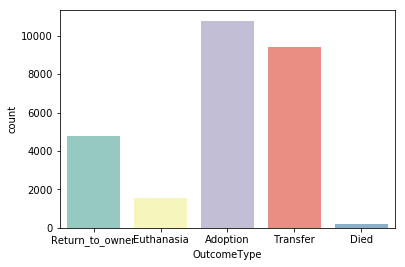

In [9]:
sns.countplot(data_train.OutcomeType, palette='Set3')
plt.show()

## 독립변수

### 1. Name

In [10]:
# Name 안에 있는 unique 갯수
data_train.Name.nunique()

6374

In [11]:
# 이름이 있는 경우 -> 'Name' / 이름이 없는 경우 -> 'No Name' 으로 변경

def no_name_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    if type(x) == float:
        return 'No Name'
    else:
        return 'Name'
    
data_train['Name'] = data_train['Name'].transform(no_name_label)

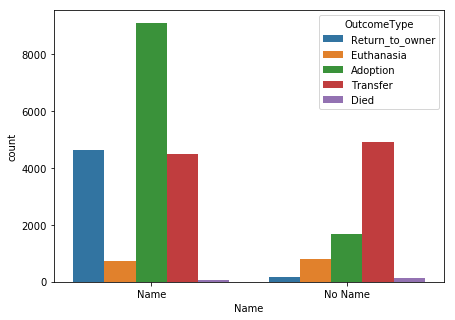

In [12]:
#이름 유/무와 OutcomeType 관계 그래프
plt.figure(figsize = (7, 5))
sns.countplot(x = 'Name', hue = 'OutcomeType', data = data_train)
plt.show()

#### 이름이 있는 경우에 주인이 찾아가는 비율이 압도적으로 높았는데, 이는 이름의 유무가 주인의 애착정도를 반영할 것이라는 애측이 타당했음을 증명한다고 보여짐.
#### 또한 이름이 있는 경우 입양되는 비율도 높았는데, 이는 이름이 있다는 것이 입양자에게 이 애완견(묘)이 이전 주인에게 사랑받고 키워졌다는 신호로 작용했을 것이라 추측함.

### 2. Date Time

In [13]:
# 날짜 데이터에서 년, 월, 일, 시간 자료 추출 및 계절 변수 형성

def datetime_str_converter(data_train):
    '''This method converts the datetime input into year and month in
    string format. The below method is identical except it returns numerical
    value. The string format is used for graphing with countplot'''
    datetime = list(data_train['DateTime'])
    year_list, month_list, day_list, hour_list = [], [], [], []
    for item in datetime:
        year_list.append(item[:4])
        month_list.append(item[5:7])
        day_list.append(item[8:10])
        hour_list.append(item[11:13])
    return year_list, month_list, day_list, hour_list

def season_sort(month_list):
    '''Converts month information to season information'''
    season_list = []
    for item in month_list:
        item = int(item)
        if item == 12 or item == 1 or item == 2:
            season_list.append('winter')
        elif item >=3 and item <=5:
            season_list.append('spring')
        elif item >= 6 and item <= 8:
            season_list.append('summer')
        elif item >= 9 and item <= 11:
            season_list.append('fall')
    return season_list

In [14]:
'''Year and Month information extraction'''
year_list, month_list, day_list, hour_list = datetime_str_converter(data_train)
date_list = []
for year, month in zip(year_list, month_list):
    date_list.append(int(year + month))

#Data를 년, 월, 일, 시간 그리고 년 + 월 합친 데이터로 변환
data_train['Date'] = date_list
data_train['OutcomeYear'], data_train['OutcomeMonth'] = year_list, month_list
data_train['OutcomeDay'], data_train['OutcomeHour'] = day_list, hour_list

#계절 데이터 형성
season_list = season_sort(month_list)
data_train['OutcomeSeason'] = season_list

In [15]:
#Data 확인
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
26724,A702446,No Name,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring
26725,A718934,No Name,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter
26726,A698128,Name,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring
26727,A677478,No Name,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring
26728,A706629,No Name,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer


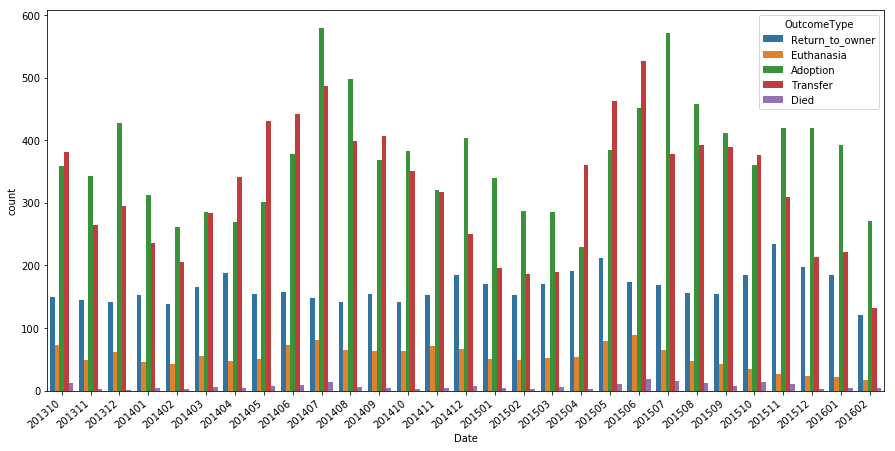

In [16]:
#날짜와 결과값 관계 그래프
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.countplot(x = 'Date', hue = 'OutcomeType', data = data_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### 보기 매우 피곤한 그래프이기 때문에 위 Reference에서 나온 factorplot 이용하여 새로운 plot형성

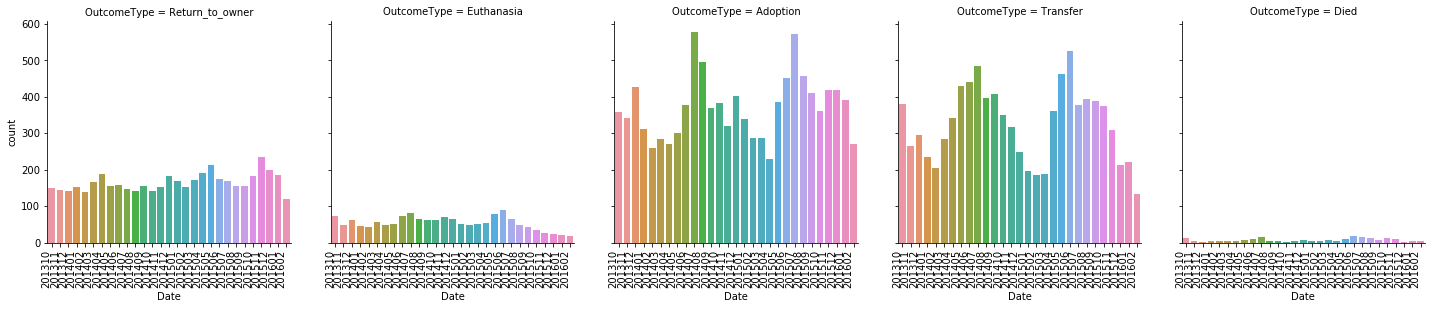

In [17]:
plt.figure(figsize=(20,20))
ax2 = sns.factorplot(x = 'Date', col = 'OutcomeType', data = data_train, kind = 'count')
ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

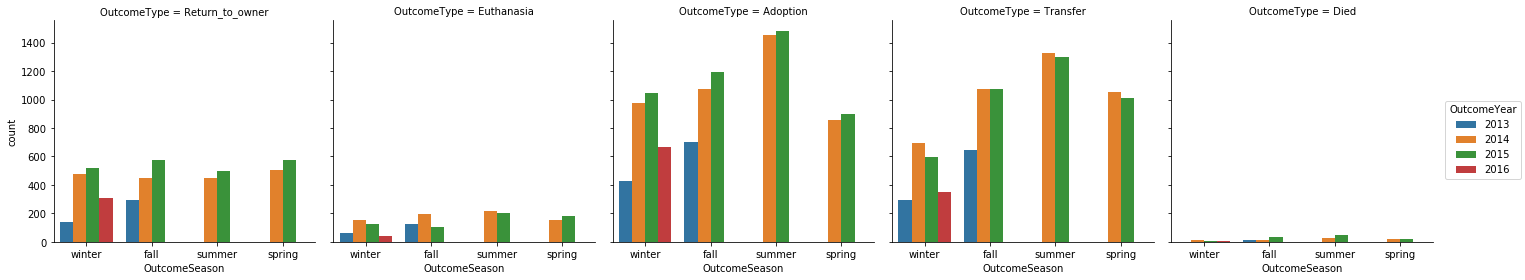

In [18]:
#계절별 OutcomeType 관계 그래프
sns.factorplot(x = 'OutcomeSeason', hue = 'OutcomeYear', col = 'OutcomeType', data = data_train, kind = 'count')
plt.show()

### 3. Animal Type

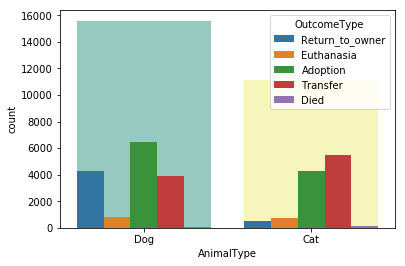

In [19]:
sns.countplot(data_train.AnimalType, palette='Set3')
sns.countplot(data=data_train, x='AnimalType',hue='OutcomeType')
plt.show()

#### 주인이 다시 찾아가는 비율은 개가 고양이에 비해서 압도적으로 높다.

### 4. SexuponOutcome

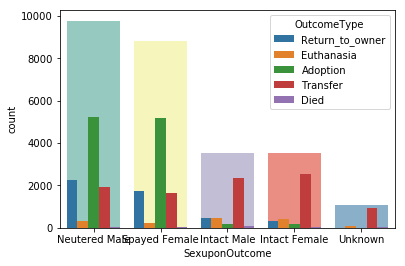

In [20]:
sns.countplot(data_train.SexuponOutcome, palette='Set3')
sns.countplot(data=data_train, x='SexuponOutcome',hue='OutcomeType')
plt.show()

#### 중성화 수술이 된 쪽이 자연상태인 쪽보다 주인이 찾아가는 비율과 입양되는 비율이 압도적으로 높았다. 
#### 자연상태의 개와 고양이는 이관되는 비율이 압도적으로 높다.

### 5. AgeuponOutcome

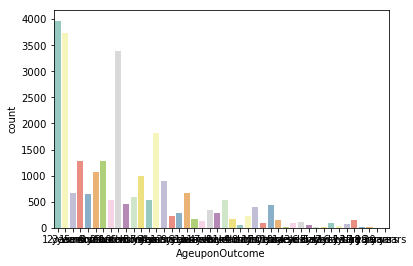

In [21]:
sns.countplot(data_train.AgeuponOutcome, palette='Set3')
plt.show()

### 너무 세분화 되어 있어서 보기 어렵다. 단순화작업 진행

In [22]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

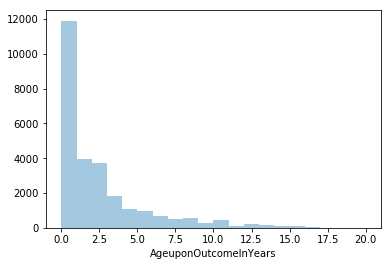

In [23]:

data_train1 = data_train.copy()
data_train1['AgeuponOutcomeInYears'] = data_train1.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(data_train1.AgeuponOutcomeInYears, bins = 20, kde=False)
plt.show()

In [24]:
def calc_age_category(x):
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'
data_train1['AgeCategory'] = data_train1.AgeuponOutcomeInYears.apply(calc_age_category)

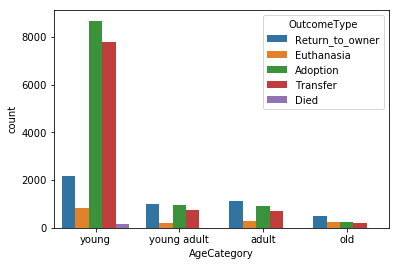

In [25]:
sns.countplot(data=data_train1, x='AgeCategory',hue='OutcomeType')
plt.show()

#### 3세 미만의 어린 개와 고양이가 입양 및 이관비율이 다른 연령대에 비해 압도적으로 높다. 
#### 10세 이상은 주인에게 돌아가는 비율이 다른 연령대에 비해 상대적으로 높다. 
* Modeling 시에는 one-hot-encoding 없이 바로 사용할 수 있도록 day를 기준으로 변환하여 사용

In [26]:
def convert_Age(data_train):
    '''Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string'''
    '''This function convert all the time into unit of day'''
    age_list = list(data_train['AgeuponOutcome'])
    age_day_compile = []
    for item in age_list:
        if type(item) != str:
            age_day_compile.append(item)
        else:
            numeric = int(item[:2])
            if 'year' in item:
                age_day_compile.append(numeric * 365)
            elif 'month' in item:
                age_day_compile.append(numeric * 30)
            elif 'week' in item:
                age_day_compile.append(numeric * 7)
            elif 'day' in item:
                age_day_compile.append(numeric)
    return age_day_compile 

In [27]:
'''This section of the code is to check the unique string values that are present in the AgeuponOutcome column'''
age_list_compile = []
age_outcome_list = list(data_train['AgeuponOutcome'])
for item in age_outcome_list:
    if type(item) != str:
        '''This condition is to account for NaN values'''
        continue
    result = ''.join(i for i in item if not i.isdigit())
    age_list_compile.append(result)
'''We can check unique string values in the column'''
age_list_unique = list(pd.Series(age_list_compile).unique())
print(age_list_unique)
'''This list contains year(s), month(s), week(s), day(s)'''

[' year', ' years', ' weeks', ' month', ' months', ' days', ' week', ' day']


'This list contains year(s), month(s), week(s), day(s)'

In [28]:
# age_list_unique 확인 결과 year, years, month, months, week, weeks, day, days의 유니크한 값을 가짐. 나이관련 변수 단위를 day로 통일

def convert_Age(data_train):
    '''Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string'''
    '''This function convert all the time into unit of day'''
    age_list = list(data_train['AgeuponOutcome'])
    age_day_compile = []
    for item in age_list:
        if type(item) != str:
            age_day_compile.append(item)
        else:
            numeric = int(item[:2])
            if 'year' in item:
                age_day_compile.append(numeric * 365)
            elif 'month' in item:
                age_day_compile.append(numeric * 30)
            elif 'week' in item:
                age_day_compile.append(numeric * 7)
            elif 'day' in item:
                age_day_compile.append(numeric)
    return age_day_compile 

In [29]:
age_day_compile = convert_Age(data_train)
data_train['AgeuponOutcome'] = age_day_compile

### 6. Breed

In [30]:
# Breed 안에 있는 unique 갯수
data_train.Breed.nunique()

1380

In [31]:
# Breed 안에 있는 values
data_train['Breed'].value_counts()

Domestic Shorthair Mix                          8810
Pit Bull Mix                                    1906
Chihuahua Shorthair Mix                         1766
Labrador Retriever Mix                          1363
Domestic Medium Hair Mix                         839
German Shepherd Mix                              575
Domestic Longhair Mix                            520
Siamese Mix                                      389
Australian Cattle Dog Mix                        367
Dachshund Mix                                    318
Boxer Mix                                        245
Miniature Poodle Mix                             233
Border Collie Mix                                229
Australian Shepherd Mix                          163
Rat Terrier Mix                                  157
Catahoula Mix                                    157
Jack Russell Terrier Mix                         146
Yorkshire Terrier Mix                            143
Domestic Shorthair                            

In [32]:
## 개 순종/잡종 분류

def dog_breed_category(data_train):
    '''This function converts the breed into pure mix, mix or pure'''
    breed_df = data_train[['OutcomeType', 'AnimalType', 'Breed']]
    breed_df_dog = breed_df[breed_df.AnimalType == 'Dog'].reset_index()
    breed_list = list(breed_df_dog['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            breed_compile.append('pure mix')
        elif '/' in item:
            breed_compile.append('mix')
        else:
            breed_compile.append('pure')
    breed_df_dog['Breed_dog'] = breed_compile
    return breed_df_dog

In [33]:
breed_df_dog = dog_breed_category(data_train)

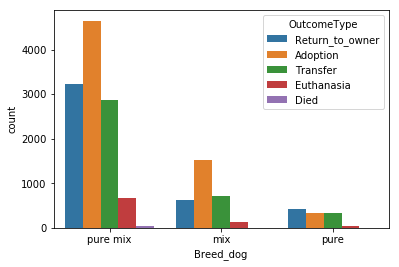

In [34]:
#순종/잡종 개와 OutcomeType 관계 그래프
sns.countplot(x = 'Breed_dog', hue = 'OutcomeType', data = breed_df_dog)
plt.show()

#### 순종견 (Pure)는 갯수가 많지 않기 때문에 Pure mix와 Pure는 같은 종으로 고려함 (타 Kaggle 분석에서도 이런식으로 진행한것 확인)

### Breed의 Unique값 분석결과 1200종이 넘는것으로 확인됨. 이러한 data를 그래로 사용할 경우 Overfitting등의 문제가 있기 때문에 2가지 방법으로 접근할 예정
  
1) 순종 Breed에 관해서는 Size로 변환 -> 잡종일 경우 유전적 factor에 의해서 크기 예측이 쉽지 않음. 이 작업을 수작업으로 하기에는 너무 많은 시간이 소요가 되기 때문에 방법 탐색중 순종을 크기 별로 나눠놓은 웹사이트 발견 -> Crawling

Mixed Breed Reference: http://www.vetstreet.com/our-pet-experts/can-you-predict-the-adult-size-of-a-mixed-breed-puppy

Size Reference : http://www.dogbreedslist.info/herding-dog-breeds/#.WgfCyMZl-iN

2) 또다른 방법은 Breed를 Main breed와 Sub breed열로 나눠서 분석

#### 1) Size별로 정리

In [35]:
# Size별 정보 Crawling by BeautifulSoup

def size_crawler(url, selector):
    '''This is one of the two functions used for crawlign cat/dog size'''
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    breed_list = soup.select(selector)
    compile_list = []
    for breed in breed_list:
        compile_list.append(breed.get_text().lower())
    return compile_list

def size_compile(url_list, selector):
    '''This is second functions used for crawlign cat/dog size'''
    list_compile = []
    for url in url_list:
        crawler_list = size_crawler(url, selector)
        list_compile += crawler_list
    return list_compile

In [36]:
'''This section is for crawling the dog size list'''

'''Extract list of dogs for different sizes'''
small_url_list = ['http://www.dogbreedslist.info/small-dog-breeds/list_2_1.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_2.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_3.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_4.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_5.html#.Wfx1Mmi0NPY',
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_6.html#.Wfx1Mmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
small_dog_compile = size_compile(small_url_list, selector)

medium_url_list = ['http://www.dogbreedslist.info/medium-dog-breeds/list_3_1.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_2.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_3.html#.Wfx3bmi0NPY', 
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_4.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_5.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_6.html#.Wfx3bmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
medium_dog_compile = size_compile(medium_url_list, selector) + ['treeing cur', 'treeing tennesse brindle']

large_url_list = ['http://www.dogbreedslist.info/large-dog-breeds/list_4_1.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_2.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_3.html#.Wfx9nWi0NPY', 
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_4.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_5.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_6.html#.Wfx9nWi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
large_dog_compile = size_compile(large_url_list, selector) + ['schnauzer giant', 'olde english bulldogge']

giant_url_list = ['http://www.dogbreedslist.info/giant-dog-breeds/list_5_1.html#.Wfx9nWi0NPY',]

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
giant_dog_compile = size_compile(giant_url_list, selector)

In [37]:
print(medium_dog_compile)

['labrador retriever', 'bulldog', 'poodle', 'boxer', 'siberian husky', 'australian shepherd', 'brittany', 'english springer spaniel', 'american cocker spaniel', 'vizsla', 'weimaraner', 'miniature american shepherd', 'border collie', 'basset hound', 'shiba inu', 'belgian malinois', 'soft coated wheaten terrier', 'portuguese water dog', 'australian cattle dog', 'airedale terrier', 'english cocker spaniel', 'bull terrier', 'whippet', 'shar-pei', 'german wirehaired pointer', 'samoyed', 'wirehaired pointing griffon', 'chow chow', 'american staffordshire terrier', 'staffordshire bull terrier', 'standard schnauzer', 'nova scotia duck tolling retriever', 'basenji', 'tibetan terrier', 'norwegian elkhound', 'wire fox terrier', 'belgian tervuren', 'boykin spaniel', 'lagotto romagnolo', 'pointer', 'american eskimo dog', 'welsh springer spaniel', 'bearded collie', 'kerry blue terrier', 'treeing walker coonhound', 'berger picard', 'redbone coonhound', 'clumber spaniel', 'german pinscher', 'field spa

In [38]:
# 순종 Mix 와 순종을 같은 Breed로 설정

def remove_mix(data_train):
    '''This function removes the keyword mix from breed list. The result from
    this method is used when converting breed into different categories'''
    breed_list = list(data_train['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            item = item[:-4]
        breed_compile.append(item)
    return breed_compile


In [39]:
breed_remove_mix = remove_mix(data_train)

In [40]:
# train.csv에 있는 모든 견종이 Crawling한 list에 존재하거나 줄임말 또는 표기법이 달라서 인식이 안되는 종이 30종 정도 있는 것으로 확인됨.
# 그 수가 그렇게 많지 않기 때문에 직접 수정함.

for index, item in enumerate(breed_remove_mix):
    if item == 'chihuahua shorthair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'collie smooth':
        breed_remove_mix[index] = 'collie'
    elif item == 'anatol shepherd':
        breed_remove_mix[index] = 'anatolian shepherd dog'
    elif item == 'port water dog':
        breed_remove_mix[index] = 'portuguese water dog'
    elif item == 'flat coat retriever':
        breed_remove_mix[index] = 'flat-coated retriever'
    elif item == 'pbgv':
        breed_remove_mix[index] = 'petit basset griffon vendeen'
    elif item == 'bruss griffon':
        breed_remove_mix[index] = 'brussels griffon'
    elif item == 'bluetick hound':
        breed_remove_mix[index] = 'bluetick coonhound'
    elif item == 'wire hair fox terrier':
        breed_remove_mix[index] = 'wire fox terrier'
    elif item == 'dachshund wirehair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'rhod ridgeback':
        breed_remove_mix[index] = 'rhodesian ridgeback'
    elif item == 'picardy sheepdog':
        breed_remove_mix[index] = 'berger picard'
    elif item == 'st. bernard rough coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item == 'old english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'chesa bay retr':
        breed_remove_mix[index] = 'chesapeake bay retriever'
    elif item == 'dachshund longhair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'chihuahua longhair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'chinese sharpei':
        breed_remove_mix[index] = 'shar-pei'
    elif item == 'standard poodle':
        breed_remove_mix[index] = 'poodle'
    elif item == 'bull terrier miniature':
        breed_remove_mix[index] = 'miniature bull terrier'
    elif item =='st. bernard smooth coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item =='redbone hound':
        breed_remove_mix[index] = 'redbone coonhound'
    elif item == 'cavalier span':
        breed_remove_mix[index] = 'cavalier king charles spaniel'
    elif item == 'collie rough':
        breed_remove_mix[index] = 'collie'
    elif item == 'german shorthair pointer':
        breed_remove_mix[index] = 'german shorthaired pointer'
    elif item == 'english pointer':
        breed_remove_mix[index] = 'pointer'
    elif item == 'mexican hairless':
        breed_remove_mix[index] = 'xoloitzcuintli'
    elif item =='dogo argentino':
        breed_remove_mix[index] = 'argentine dogo'
    elif item == 'queensland heeler':
        breed_remove_mix[index] = 'australian cattle dog'

In [41]:
# 고양이 사이즈 : 고양이는 종류가 강아지만큼 다양하지 않기 때문에 수작업 전처리 진행

small_cat_list = ['munchkin longhair']
medium_cat_list = ['exotic shorthair', 'persian', 'abyssinian', 'sphynx', 'siamese',
                   'cornish rex', 'devon rex', 'burmese', 'tonkinese', 'russian blue', 
                   'manx', 'japanese bobtail', 'balinese', 'bombay', 'havana brown',
                   'bengal', 'cymric', 'himalayan', 'snowshoe', 'javanese', 'havana brown', 'angora']
large_cat_list = ['american shorthair', 'british shorthair', 'norwegian forest cat', 'ocicat',
                  'turkish van', 'pixiebob shorthair', 'maine coon', 'ragdoll']
domestic = ['domestic longhair', 'domestic medium hair', 'domestic shorthair']

고양이종에 domestic이 붙은 종은 북미지역에 서식하는 잡종 고양이를 뜻함. train 데이터에서도 압도적으로 많은 고양이들이 domestic 종이고 실제로도 북미지역 애완 고양이는 높은 비율로 domestic 잡종인것을 아래 참조 자료를 통해 확인하였음. 잡종인 만큼 size를 예측하기 힘들기 때문에 domestic이라는 카테고리를 따로 형성함

#### Reference: http://www.petguide.com/breeds/cat/domestic-longhair/

In [42]:
# mapping : 개는 1, 고양이는 0 으로 전처리

animal_type_mapping = {'Dog':1, 'Cat':0}
data_train['AnimalType'] = data_train['AnimalType'].map(animal_type_mapping)

In [43]:
# 개/고양이 Size 인자 형성

# Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings

def convert_breed(type_list, breed_list, small_list, medium_list, large_list, giant_list,
                  small_cat_list, medium_cat_list, large_cat_list, domestic_cat_list):
    '''Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings
    that is a really smart and succinct solution for checking substring existence in a list of strings'''
    
    '''The incoming list a list of breeds with the keyword "mix" removed and converted
    to lower case. No need for extra preprocessing. Also the dog lists are all converted
    to lower case as well. Type list is to check whether the breed belongs to dog or cat'''
    if len(type_list) != len(breed_list):
        print('Two lists must have equal length!')
        return None
    
    '''Convert the list into a string format for easier processing'''
    small_combined = '\t'.join(small_list)
    medium_combined = '\t'.join(medium_list)
    large_combined = '\t'.join(large_list)
    giant_combined = '\t'.join(giant_list)
    
    breed_compile, excluded_list, mix_breed_list, cat_breed_list = [], [], [], []
    for animal_type, breed in zip(type_list, breed_list):
        if '/' in breed: #Mixed type categorization
            mix_breed_list.append(breed)
            breed_compile.append('mix')
        elif animal_type == 0: #Cat breed categorization
            cat_breed_list.append(breed)
            if breed in small_cat_list:
                breed_compile.append('small_cat')
            elif breed in medium_cat_list:
                breed_compile.append('medium_cat')
            elif breed in large_cat_list:
                breed_compile.append('large_cat')
            elif breed in domestic_cat_list:
                breed_compile.append('domestic')
        elif animal_type == 1: #Dog breed categorization
            if breed in small_combined:
                breed_compile.append('small')
            elif breed in medium_combined:
                breed_compile.append('medium')
            elif breed in large_combined:
                breed_compile.append('large')
            elif breed in giant_combined:
                breed_compile.append('giant')
            else:
                excluded_list.append(breed)
                breed_compile.append('unknown')
    return breed_compile, excluded_list, mix_breed_list, cat_breed_list

In [44]:
'''Compare the breed in the data to crawled size lists and create a list indicating
the size of each breed. By zipping two lists, we can also ignore species that
belong to cats. Some breed names were manually modified to fit the crawled list'''
type_list = list(data_train['AnimalType'])

convert_list, excluded_list_dog, mix_breed_list_dog, cat_breed_list = convert_breed(type_list, 
                                     breed_remove_mix, small_dog_compile, 
                                     medium_dog_compile, large_dog_compile, giant_dog_compile,
                                     small_cat_list, medium_cat_list, large_cat_list, domestic)

'''With the manual correction to dog breed, this list should only contain unknown values'''
excluded_unique_dog = list(set(excluded_list_dog))
print(excluded_unique_dog)

['unknown']


In [45]:
'''Whew finally add the cleansed convert_dog_list to our data_train DataFrame'''
data_train['Size'] = convert_list
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size
26724,A702446,No Name,2015-05-14 11:56:00,Transfer,Partner,0,Intact Male,30.0,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring,domestic
26725,A718934,No Name,2016-01-20 18:59:00,Transfer,SCRP,0,Spayed Female,90.0,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter,domestic
26726,A698128,Name,2015-03-09 13:33:00,Adoption,NaN,1,Neutered Male,1460.0,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring,large
26727,A677478,No Name,2014-04-27 12:22:00,Transfer,Partner,0,Intact Male,28.0,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring,domestic
26728,A706629,No Name,2015-07-02 09:00:00,Transfer,SCRP,0,Intact Male,365.0,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer,domestic


In [46]:
'''Confirm that only expected values small, medium, large, giant, unknown and domestic
are present in the Size column'''
size_check_list = list(data_train['Size'].unique())

In [47]:
print(size_check_list)

['small', 'domestic', 'medium', 'mix', 'giant', 'medium_cat', 'large', 'large_cat', 'unknown', 'small_cat']


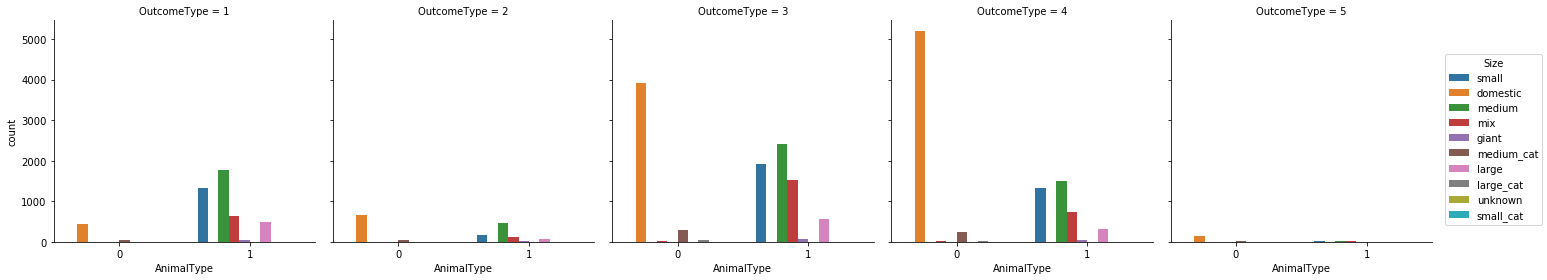

In [80]:
sns.factorplot(x = 'AnimalType', hue = 'Size', col = 'OutcomeType', data = data_train, kind = 'count')
plt.show()

#### 고양이 경우 앞서 말했듯이 domestic종이 다른 종에 비해 압도적으로 많은 것으로 확인됨. 따라서 차후 머신러닝 알고리즘 적용시 고양이와 개의 분류는 AnimalType에 의해서 이루어 질지 아니면 domestic이라는 종에 의해서 이루어 질지 확인해볼 필요가 있음

#### 완변하진 않지만 각각 결과값에 따른 애완견 사이즈별 비율이 비슷한 형태를 하고 있는것으로 판단됨. 어쩌면 size가 생각보다 중요하지 않은 인자일수도? 

#### 2) Main/Sub 로 분리

In [49]:
# 종이 3개 이상 섞여 있는 경우의 갯수
check_breed = list(data_train['Breed'])
count = 0
for item in check_breed:
    if item.count('/') == 2:
        count += 1
print(count)

10


#### 10개밖에 없기때문에 잡종일 경우 main과 sub로만 분리 (원래 계획은 sub1, sub2로 나눌 계획이었음)

In [50]:
def breed_separator(breed_remove_mix):
    '''This function separates the breed into main and sub breed columns'''
    main_breed, sub_breed = [], []
    for breed in breed_remove_mix:
        if breed.count('/') == 0:
            main_breed.append(breed)
            sub_breed.append('NA')
        elif breed.count('/') == 1 or breed.count('/') == 2:
            temp_breed_list = breed.split('/')
            main_breed.append(temp_breed_list[0])
            sub_breed.append(temp_breed_list[1])
    return main_breed, sub_breed

In [51]:
main_breed, sub_breed = breed_separator(breed_remove_mix)
data_train['Main_Breed'], data_train['Sub_Breed'] = main_breed, sub_breed

### 7. Color

In [52]:
def color_separator(color_list):
    '''The function separates color into main and sub colors'''
    main_color, sub_color = [], []
    for color in color_list:
        if color.count('/') == 0:
            main_color.append(color)
            sub_color.append('NA')
        elif color.count('/') == 1:
            temp_color_list = color.split('/')
            main_color.append(temp_color_list[0])
            sub_color.append(temp_color_list[1])
    return main_color, sub_color

In [53]:
color_list = list(data_train['Color'])
main_color, sub_color = color_separator(color_list)
data_train['Main_Color'], data_train['Sub_Color'] = main_color, sub_color

In [54]:
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color
26724,A702446,No Name,2015-05-14 11:56:00,Transfer,Partner,0,Intact Male,30.0,Domestic Shorthair Mix,Brown Tabby/White,...,2015,05,14,11,spring,domestic,domestic shorthair,NA,Brown Tabby,White
26725,A718934,No Name,2016-01-20 18:59:00,Transfer,SCRP,0,Spayed Female,90.0,Domestic Shorthair Mix,Brown Tabby,...,2016,01,20,18,winter,domestic,domestic shorthair,NA,Brown Tabby,NA
26726,A698128,Name,2015-03-09 13:33:00,Adoption,NaN,1,Neutered Male,1460.0,Old English Bulldog Mix,White/Tan,...,2015,03,09,13,spring,large,olde english bulldogge,NA,White,Tan
26727,A677478,No Name,2014-04-27 12:22:00,Transfer,Partner,0,Intact Male,28.0,Domestic Shorthair Mix,Black,...,2014,04,27,12,spring,domestic,domestic shorthair,NA,Black,NA
26728,A706629,No Name,2015-07-02 09:00:00,Transfer,SCRP,0,Intact Male,365.0,Domestic Shorthair Mix,Brown Tabby/White,...,2015,07,02,09,summer,domestic,domestic shorthair,NA,Brown Tabby,White


### cf) OutcomeSubtype

In [55]:
# OutcomeSubtype 의 Missing Value 는 'Unknown'으로 대체함.
data_train['OutcomeSubtype'] = data_train['OutcomeSubtype'].fillna('Unknown')

In [56]:
data_train['OutcomeSubtype'].unique()

array(['Unknown', 'Suffering', 'Foster', 'Partner', 'Offsite', 'SCRP',
       'Aggressive', 'Behavior', 'Rabies Risk', 'Medical', 'In Kennel',
       'In Foster', 'Barn', 'Court/Investigation', 'Enroute', 'At Vet',
       'In Surgery'], dtype=object)

In [57]:
def convert_subtype(data_train):
    '''Convert OutcomeSubtype into numerical values'''
    subtype_unique = list(data_train['OutcomeSubtype'].unique())
    subtype_mapping = {}
    for i, item in enumerate(subtype_unique):
        if item == 0:
            continue
        else:
            subtype_mapping[item] = i
    data_train['OutcomeSubtype'] = data_train['OutcomeSubtype'].map(subtype_mapping)
    return data_train, subtype_mapping

In [58]:
#data_train, outComeSubtype_mapping = convert_subtype(data_train)

In [59]:
#data_train['OutcomeSubtype'] = data_train['OutcomeSubtype'].fillna(0)

In [60]:
#data_train.tail()

In [61]:
data_train.shape

(26729, 21)

In [62]:
# Nan Value 제거
data_train = data_train.dropna()
data_train.shape

(26710, 21)

### One-Hot-Encoding

In [63]:
# get_dummies 를 이용한 One-Hot-Encoding

main_color_le = pd.get_dummies(data_train[['Main_Color']])
sub_color_le = pd.get_dummies(data_train[['Sub_Color']])
main_breed_le = pd.get_dummies(data_train[['Main_Breed']])
sub_breed_le = pd.get_dummies(data_train[['Sub_Breed']])
year_le = pd.get_dummies(data_train[['OutcomeYear']])
month_le = pd.get_dummies(data_train[['OutcomeMonth']])
day_le = pd.get_dummies(data_train[['OutcomeDay']])
hour_le = pd.get_dummies(data_train[['OutcomeHour']])
size_le = pd.get_dummies(data_train['Size'])
sex_le = pd.get_dummies(data_train['SexuponOutcome'])
season_le = pd.get_dummies(data_train[['OutcomeSeason']])
outcomesubtype_le = pd.get_dummies(data_train[['OutcomeSubtype']])

In [64]:
year_le.head()

,OutcomeYear_2013,OutcomeYear_2014,OutcomeYear_2015,OutcomeYear_2016
0,0,1,0,0
1,1,0,0,0
2,0,0,1,0
3,0,1,0,0
4,1,0,0,0


In [65]:
size_le.head()

,domestic,giant,large,large_cat,medium,medium_cat,mix,small,small_cat,unknown
0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [66]:
sex_le.head()

,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [67]:
outcomesubtype_le.head()

,OutcomeSubtype_Aggressive,OutcomeSubtype_At Vet,OutcomeSubtype_Barn,OutcomeSubtype_Behavior,OutcomeSubtype_Court/Investigation,OutcomeSubtype_Enroute,OutcomeSubtype_Foster,OutcomeSubtype_In Foster,OutcomeSubtype_In Kennel,OutcomeSubtype_In Surgery,OutcomeSubtype_Medical,OutcomeSubtype_Offsite,OutcomeSubtype_Partner,OutcomeSubtype_Rabies Risk,OutcomeSubtype_SCRP,OutcomeSubtype_Suffering,OutcomeSubtype_Unknown
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [68]:
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color
26724,A702446,No Name,2015-05-14 11:56:00,Transfer,Partner,0,Intact Male,30.0,Domestic Shorthair Mix,Brown Tabby/White,...,2015,05,14,11,spring,domestic,domestic shorthair,NA,Brown Tabby,White
26725,A718934,No Name,2016-01-20 18:59:00,Transfer,SCRP,0,Spayed Female,90.0,Domestic Shorthair Mix,Brown Tabby,...,2016,01,20,18,winter,domestic,domestic shorthair,NA,Brown Tabby,NA
26726,A698128,Name,2015-03-09 13:33:00,Adoption,Unknown,1,Neutered Male,1460.0,Old English Bulldog Mix,White/Tan,...,2015,03,09,13,spring,large,olde english bulldogge,NA,White,Tan
26727,A677478,No Name,2014-04-27 12:22:00,Transfer,Partner,0,Intact Male,28.0,Domestic Shorthair Mix,Black,...,2014,04,27,12,spring,domestic,domestic shorthair,NA,Black,NA
26728,A706629,No Name,2015-07-02 09:00:00,Transfer,SCRP,0,Intact Male,365.0,Domestic Shorthair Mix,Brown Tabby/White,...,2015,07,02,09,summer,domestic,domestic shorthair,NA,Brown Tabby,White


# Feature Selection

### 불필요한 변수 제거

In [69]:

data_train.drop('AnimalID', axis = 1, inplace = True)

# DateTime 은 연/월/일/시간으로 변환하여 이미 반영되었음.
data_train.drop('DateTime', axis = 1, inplace = True)
data_train.tail()

/Users/Dong-hyun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Dong-hyun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color
26724,No Name,Transfer,Partner,0,Intact Male,30.0,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring,domestic,domestic shorthair,NA,Brown Tabby,White
26725,No Name,Transfer,SCRP,0,Spayed Female,90.0,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter,domestic,domestic shorthair,NA,Brown Tabby,NA
26726,Name,Adoption,Unknown,1,Neutered Male,1460.0,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring,large,olde english bulldogge,NA,White,Tan
26727,No Name,Transfer,Partner,0,Intact Male,28.0,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring,domestic,domestic shorthair,NA,Black,NA
26728,No Name,Transfer,SCRP,0,Intact Male,365.0,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer,domestic,domestic shorthair,NA,Brown Tabby,White


### 툴을 사용하기 위해 str -> int로 바꾸는 작업

In [70]:
#Name
def no_name_numeric_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    '''This function is used in conjunction with .transform() method to convert Name and No Name 
    to numerical values'''
    if x == 'No Name':
        return 0
    else:
        return 1

data_train['Name'] = data_train['Name'].transform(no_name_numeric_label)

/Users/Dong-hyun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [71]:
# AgeuponOutcome 과 AnimalType은 위에서 이미 처리하였음.

In [72]:
# OutcomeType

outcome_mapping = {'Return_to_owner':1, 'Euthanasia':2, 'Adoption':3, 'Transfer':4, 'Died':5}
data_train['OutcomeType'] = data_train['OutcomeType'].map(outcome_mapping)

/Users/Dong-hyun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [73]:
def greedy_selector(dfX_list, dfY):
    '''This function performs greedy feature selection. dfX_list contains various combinations of features that will be used'''
    train_compile, test_compile, logLoss_compile = [], [], []
    
    for dfX in dfX_list:
        dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX, dfY, test_size = 0.25, random_state=0)
        '''nthread parameter is the paralleization parameter. This forces XGBoost to utilize all the CPU power available'''
        model_xgb = xgboost.XGBClassifier(n_estimators = 100, max_depth = 2, nthread = -1)
        model_xgb.fit(dfX_train, dfY_train)

        '''Let us save train and test accuracy along with log loss'''
        y_pred_train = model_xgb.predict(dfX_train)
        train_accuracy = accuracy_score(dfY_train, y_pred_train)
        train_compile.append(train_accuracy)

        y_pred_test = model_xgb.predict(dfX_test)
        test_accuracy = accuracy_score(dfY_test, y_pred_test)
        test_compile.append(test_accuracy)

        y_proba = model_xgb.predict_proba(dfX_test)
        logLoss = log_loss(dfY_test, y_proba)
        logLoss_compile.append(logLoss)
        
    return train_compile, test_compile, logLoss_compile

Feature Selection은 원래 feature_importance할 예정이었으나 위에 get_dummies method를 통해 본 결과 인자수가 어마어마 하다는것을 알수있다 (대략 530개 정도). 또한 인자끼리 관계도 또한 무시할수 없기 때문에 고민하던중, 우선 XGBoost를 이용해서 Greedy 한 방식으로 feature selection을 진행하기로 했다. 정식대로라면 사용하려는 feature마다 모델 최적화를 하면서 결과값을 비교하는것이 정상이지만 그렇게 할려하니 시간도 오래 걸리고 해서 차선책으로 Greedy방식으로 진행 해보기로 했다.

In [74]:
%%time
'''dfY is always fixed'''
dfY = data_train['OutcomeType']

dummy_cont = data_train[['Name', 'AnimalType', 'AgeuponOutcome']]

dfX = pd.concat([dummy_cont, main_breed_le, main_color_le, month_le, year_le, sex_le], axis = 1)
dfX2 = pd.concat([dummy_cont, main_breed_le, sub_breed_le, main_color_le, sub_color_le, month_le, year_le, sex_le], axis = 1)
dfX3 = pd.concat([dummy_cont, size_le, main_color_le, sub_color_le, month_le, year_le, sex_le], axis = 1)
dfX4 = pd.concat([dummy_cont, size_le, main_breed_le, sub_breed_le, main_color_le, sub_color_le, month_le, year_le, sex_le], axis = 1)
dfX5 = pd.concat([dummy_cont, main_breed_le, sub_breed_le, main_color_le, sub_color_le, season_le, sex_le], axis = 1)
dfX6 = pd.concat([dummy_cont, size_le, main_breed_le, sub_breed_le, main_color_le, sub_color_le, 
                 year_le, month_le, day_le, hour_le, sex_le], axis = 1)
dfX7 = pd.concat([dummy_cont, size_le, main_breed_le, sub_breed_le, main_color_le, sub_color_le, 
                 year_le, month_le, day_le, hour_le, sex_le, outcomesubtype_le], axis = 1)

dfX_list = [dfX, dfX2, dfX3, dfX4, dfX5, dfX6, dfX7]
train_compile, test_compile, logLoss_compile = greedy_selector(dfX_list, dfY)

CPU times: user 9min 10s, sys: 5.95 s, total: 9min 16s
Wall time: 2min 41s


In [ ]:
# 위의 결과값 저장

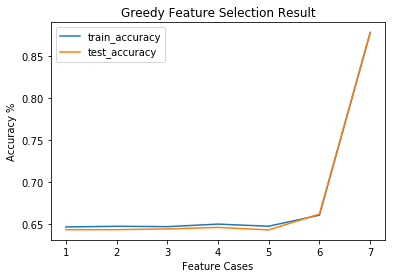

In [81]:
plt.plot(range(1, 8), train_compile, label = 'train_accuracy')
plt.plot(range(1, 8), test_compile, label = 'test_accuracy')
plt.legend()
plt.xlabel('Feature Cases')
plt.ylabel('Accuracy %')
plt.title('Greedy Feature Selection Result')
plt.show()

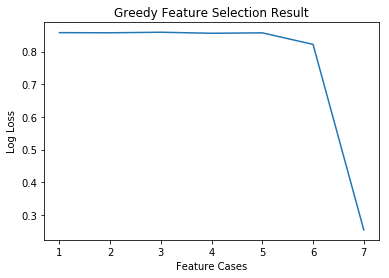

In [76]:
plt.plot(range(1, 8), logLoss_compile)
plt.xlabel('Feature Cases')
plt.ylabel('Log Loss')
plt.title('Greedy Feature Selection Result')
plt.show()

#### OutcomeSubtype 첨부시 모델 정확도가 급증가 하는것으로 파악됨. 모델 최적화 없이도 Kaggle점수 2등 수준의 점수가 나오지만 test.csv에는 OutcomeSubtype이 없으며 실제 결과와 너무 직관적으로 연관된 인자라 사용 X

#### 나머지 인자 비교시, 다른 인자보다 DateTime의 Day, Hour정보 첨부시 정확도와 log loss 값이 많이 올라가는것이 보임 (Case 6번)

# Modeling

## Logistic

## LDA

## Random Forest

## XG_boost

### Max depth와 n_estimator를 한번에 최적화 하려고 시도했으나, 실행에 너무 많은 시간이 걸려서, 우선 각각 분석진행 후 Greedy한 방식으로 최적조건 도출

In [85]:
dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX6, dfY, test_size = 0.25, random_state=0)

In [82]:
# Max depth와 n_estimator 한번에 최적화 시도
# 10시간이 지나도 계산이 끝나지 않음.

def xgboost_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_xgb = xgboost.XGBClassifier(nthread = -1)
    parameters = {'max_depth': [5, 6, 7, 8, 9], 'n_estimators': [100, 300, 500, 1000]}
    
    gs = GridSearchCV(estimator = model_xgb, param_grid = parameters, scoring = 'neg_log_loss', cv = 4, n_jobs = -1)
    %time gs = gs.fit(dfX, dfY)
    return gs

# %%time
# gs_estimator = xgboost_optimizer_estimator(dfX_train, dfY_train)

# gs_estimator.cv_results_["mean_test_score"]

# plt.plot([100, 300, 500, 1000], -1 * gs_estimator.cv_results_["mean_test_score"])
# plt.xlabel('n_estimators')
# plt.ylabel('log-loss')
# plt.title('XGBoost GridSearch with respect to n_estimators')

In [86]:
def xgboost_optimizer_depth(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_xgb = xgboost.XGBClassifier(nthread = -1)
    parameters = {'max_depth': [5, 6, 7, 8, 9], 'n_estimators': [100]}
    
    gs = GridSearchCV(estimator = model_xgb, param_grid = parameters, scoring = 'neg_log_loss', cv = 15, n_jobs = -1)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [ ]:
%%time
gs_depth = xgboost_optimizer_depth(dfX_train, dfY_train)

In [ ]:
# 위의 결과값 저장

In [ ]:
gs_depth.cv_results_["mean_test_score"]

plt.plot([5, 6, 7, 8, 9], -1 * gs_depth.cv_results_["mean_test_score"])
plt.xlabel('max_depth')
plt.ylabel('log-loss')
plt.title('XGBoost GridSearch with respect to max_depth')
plt.show()

#### 위 두개 결과를 바탕으로 max_depth = 7, n_estimator = 500으로 설정하요 XGBoost실행

In [ ]:
%%time
model_xgb = xgboost.XGBClassifier(max_depth = 7, n_estimators = 500, nthread = -1)
model_xgb.fit(dfX_train, dfY_train)

y_pred_train = model_xgb.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_xgb.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_xgb.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [ ]:
# 위의 결과값 저장

In [ ]:
print('Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

In [ ]:
print(classification_report(dfY_test, y_pred_test))

## Model Selection

In [ ]:
test set 불러와서 돌려보기

사용features 
* Name
* 

사용모델 : XG_Boost
Parameter 설정
* Max_depth : 7
* n_estimator : 

평가 : Log_loss
* train set : 
* test set : 

Kaggle 순위 :     (비고 : 1위_ / 2위_ / 10위_ / 100위_)




Kaggle Leaderboard에서 476등 점수 확보 (총 참가팀 1604팀). 하지만 Leaderboard를 보면 알수 있듯이 상위 랭커와 큰 점수차는 없는것으로 판단 (log loss 0.7점 받은 팀이 53등). 또한  아랫부분 Kaggle 결과값 논란 부분에서 언급하겠지만 많은 팀들이 Kaggle에서 주어진 데이터 이외에 외부 데이터를 가지고 와서 분석한것으로 판단됨.

#### Feature importance 분석

In [ ]:
'''Feature importance analysis code'''
'''Reference: Python Machine Learning'''
feat_labels = np.array(dfX6.columns)
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs = -1)
forest.fit(dfX_train, dfY_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:30]

for f in range(len(indices)):
    print("%2d %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]] ))

plt.figure(figsize = (7, 7))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), feat_labels[indices], rotation=90)
plt.tight_layout()
plt.show()